# Logistic map

In [1]:
# This is a standard initalisation code - no need to change this
# It loads basic fast array code, plot library and ODE solver
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
%config InlineBackend.figure_formats={'retina','png'}

Defining the map instelf $x_{n+1}=r x_n(1-x_n)$

In [2]:
def lmap(x,r):
    return r*x*(1-x)

## Cobwebs

In [3]:
def plot_cobweb(r, x0=0.25, npoints=500):    
    xran=np.linspace(0,1, num=100)

    fig1, ax1 = plt.subplots(1) # get figure and "axes". They can be reused later.
    ax1.plot(xran, xran)
    ax1.plot(xran, lmap(xran,r))
    ax1.set_xlabel("$x_n$")
    ax1.set_ylabel("$x_{n+1}$")

    # Initial iterations in green
    x = x0
    for i in range(npoints):
        x2 = lmap(x, r)
        ax1.plot([x,x,x2],[x,x2,x2], color="green", linewidth=0.5)
        x = x2
    # limit cycle in black
    for i in range(npoints):
        x2 = lmap(x, r)
        ax1.plot([x,x,x2],[x,x2,x2], color="black", linewidth=0.5)
        x = x2

The iterations converge fast for smaller $r$

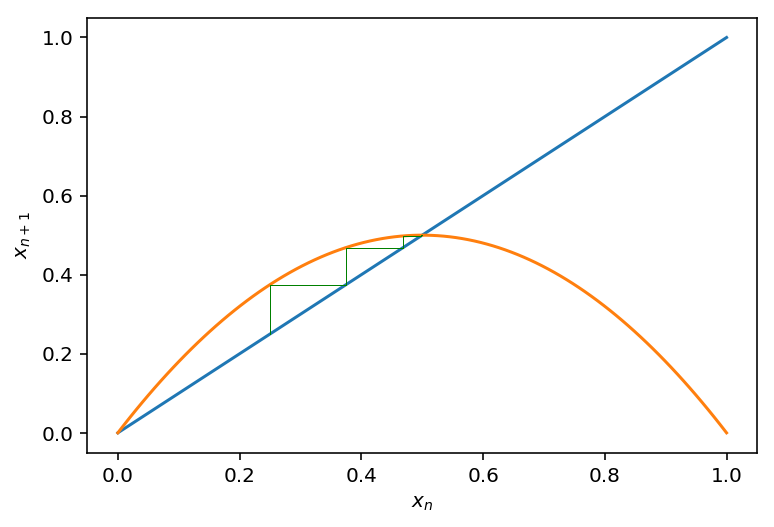

In [4]:
plot_cobweb(2)

Approach a cycle fo rlarger $r$

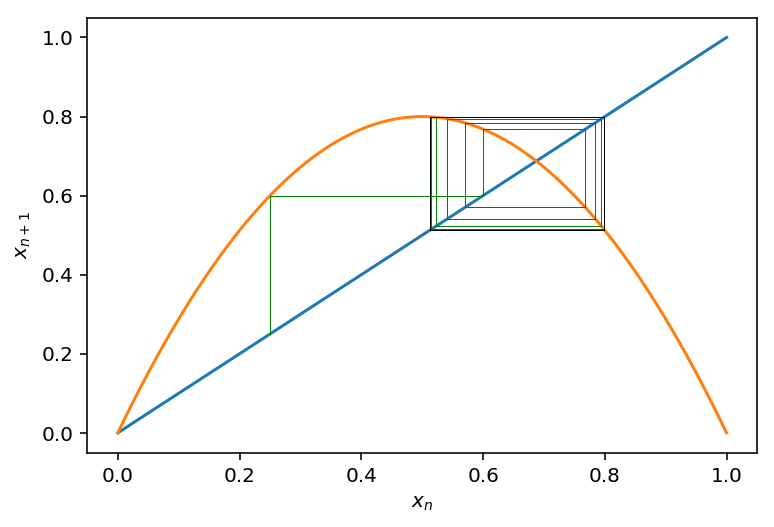

In [5]:
plot_cobweb(3.2)

And are chaotic for even larger $r$

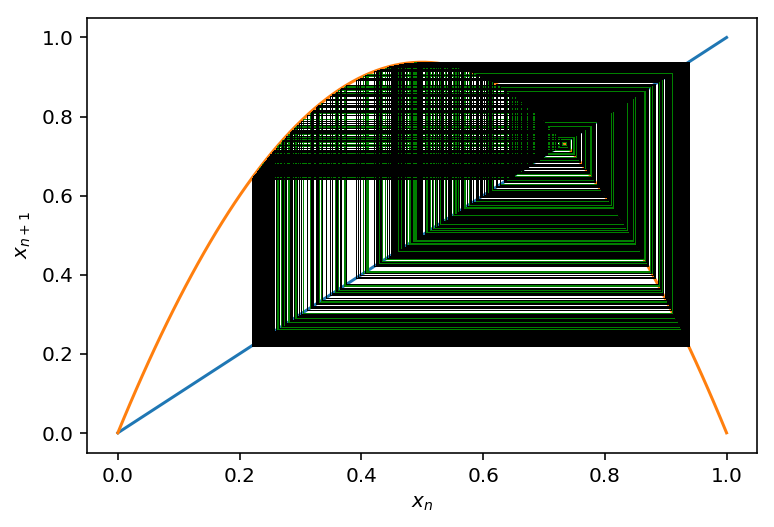

In [6]:
plot_cobweb(3.75)

## The limiting points for all $r$

Function returning the limit cycle -- iterate for some (1000) iterations to get to teh limit cycle, and then iterate next bunch of iterations to get the cycle.

In [7]:
def get_cycle(r, x0=0.25, npoints=1000):
    x = x0
    for i in range(npoints):
        x = lmap(x,r)
    cycles = []
    for i in range(npoints):
        x = lmap(x,r)
        cycles.append(x)
    return np.unique(cycles)

An let us plot the map!

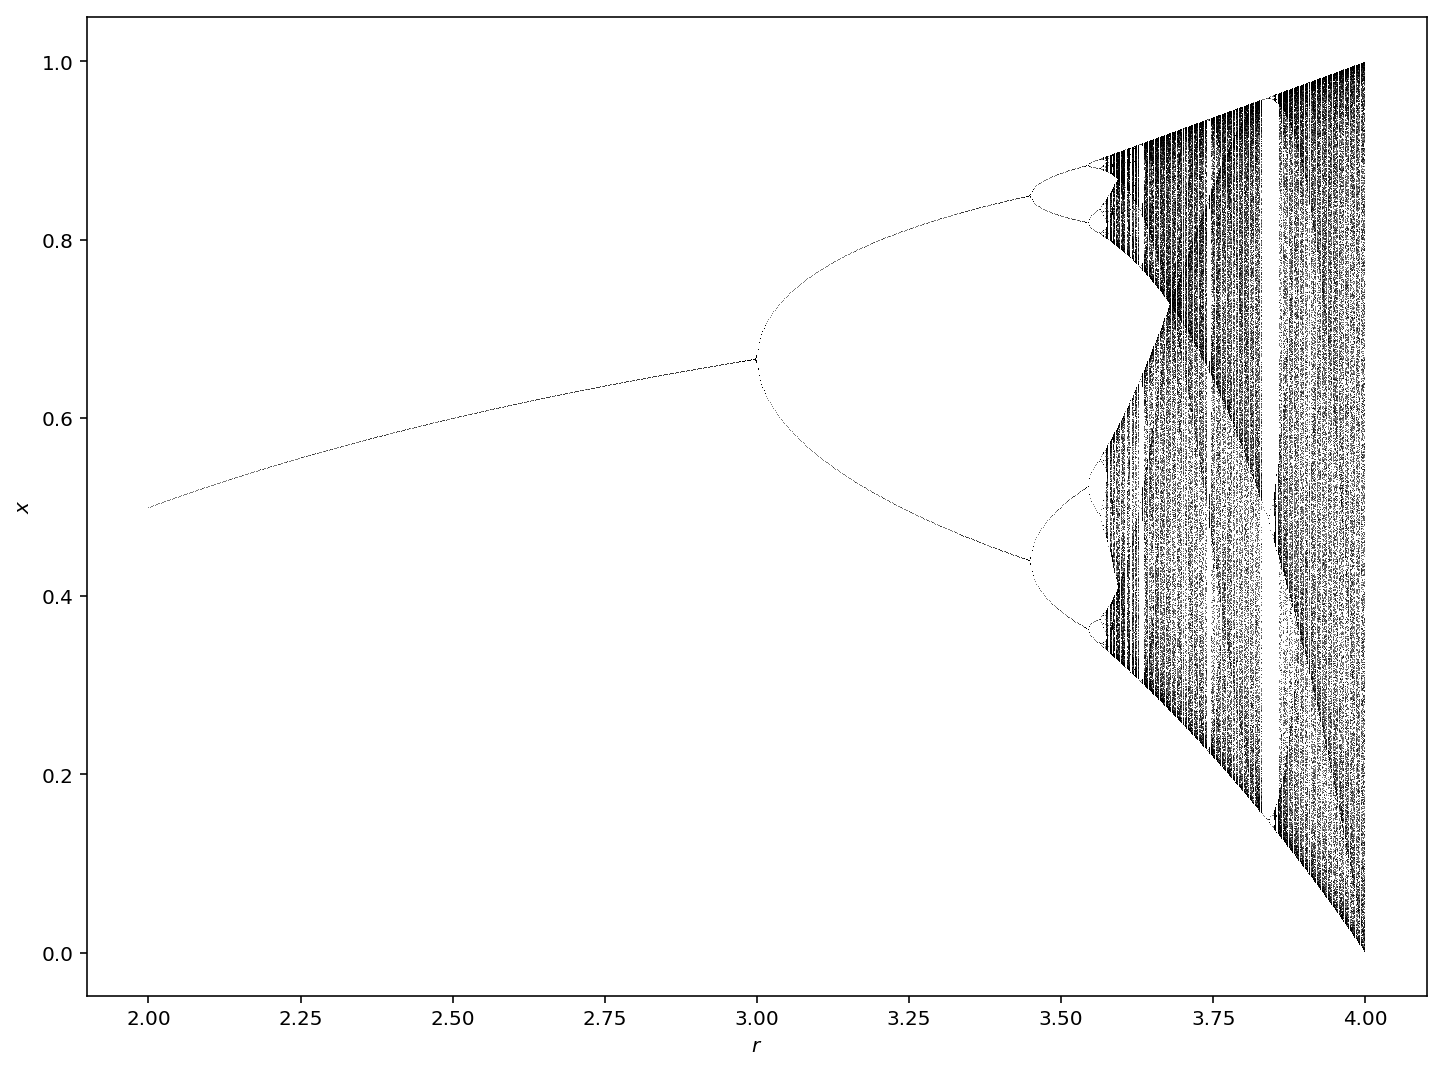

In [22]:
rran=np.linspace(2, 4, num=1000) # You can change the range to "zoom"
## rran=np.linspace(3.5, 3.7, num=1000)

fig2 = plt.figure(figsize=(12, 9))
ax2 = fig2.subplots(1) # get figure and "axes". They can be reused later.
ax2.set_xlabel("$r$")
ax2.set_ylabel("$x$")

for r in rran:
    cycle = get_cycle(r)
    rr = np.full_like(cycle, r)
    ax2.scatter(rr, cycle, lw=0, s=0.1, color="black")